In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from numpy.core.fromnumeric import mean
from sklearn.neighbors import KNeighborsClassifier
from networkx.algorithms.community.label_propagation import label_propagation_communities

import networkx.algorithms.community as nx_comm
from networkx.algorithms.community import modularity
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB

In [ ]:
!pip install EoN
import EoN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120793 sha256=48b6220e73053d1c8846bd2179e87d87419570edd6164ccd9c009384eec919f4
  Stored in directory: /root/.cache/pip/wheels/cc/38/06/01956d0db50e69cbcd6752d4b362685690c4fc17a80674bf18
Successfully built EoN


# Step 1

### Reading the files and extracting the data

In [ ]:
# nodes file
nodes_df = pd.read_excel('nodes.xlsx', usecols=['NodeId', 'Labels'])
nodes = nodes_df.values.tolist()

# edges file
edges_df = pd.read_excel('edges.xlsx', usecols=['sourceNodeId', 'targetNodeId'])
edges = edges_df.values.tolist()

### Create Directed Graph and add nodes and edges

In [ ]:
G = nx.DiGraph()
G.add_nodes_from([(node_id, {'label': label}) for node_id, label in nodes])
G.add_edges_from(edges)

In [ ]:
# Get the positions of the nodes
pos = nx.spring_layout(G, scale=50 , seed= 1234)

In [ ]:
print(G)

DiGraph with 2708 nodes and 10556 edges


### A. plot the graph

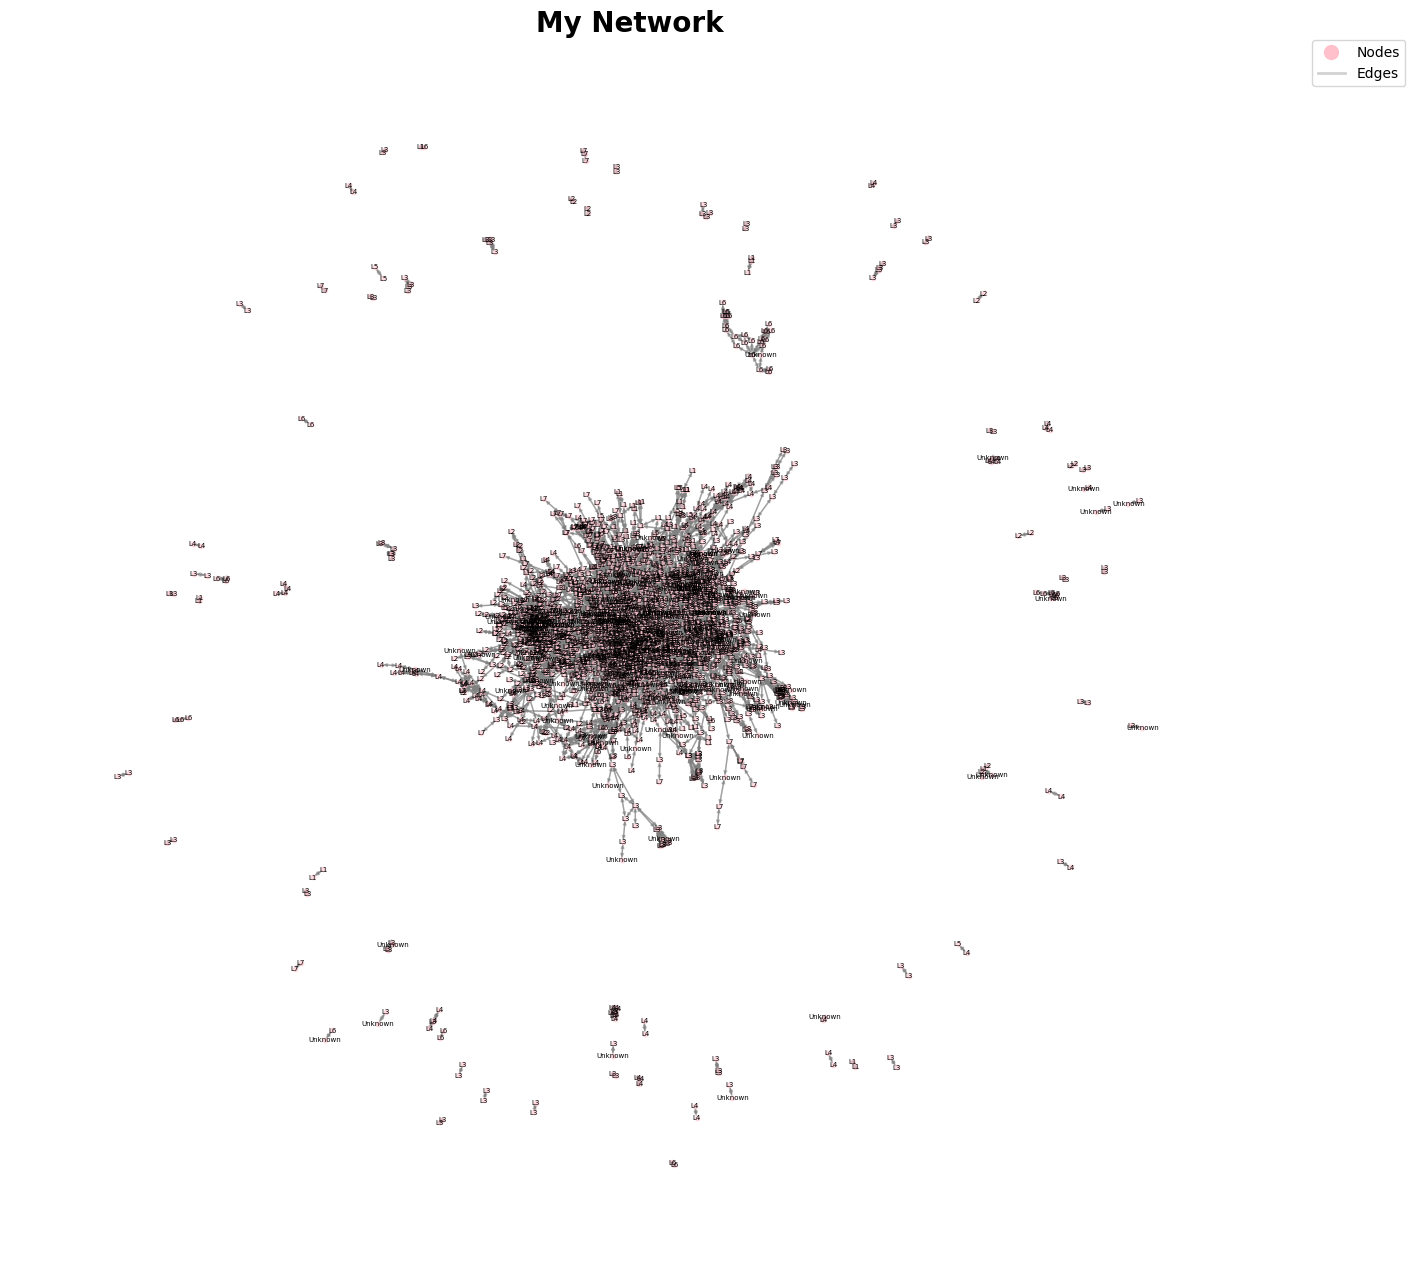

In [ ]:
# Draw the graph
fig, ax = plt.subplots(figsize=(16, 16))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='pink', alpha=0.5, ax=ax)
nx.draw_networkx_edges(G, pos, node_size=10, edge_color='gray', arrowsize=5, alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, labels={node_id: label for node_id, label in nodes}, font_size=5, font_family='sans-serif', ax=ax)
ax.set_axis_off()
ax.set_title('My Network', fontsize=20, fontweight='bold')

# Add legend
pink_patch = plt.plot([],[], marker="o", ms=10, ls="", mec=None, color="pink", label="Nodes")
gray_patch = plt.plot([],[], lw=2, color="lightgray", label="Edges")
plt.legend(handles=[pink_patch[0], gray_patch[0]],
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


### B. Statistical Metrics

In [ ]:
!pip install tabulate
from tabulate import tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Calculate the statistical information
print('Our statistics are:')
degrees = dict(G.degree())
total_degree = sum(degrees.values())
print(f'Total Degree: {total_degree}')

total_edges = G.number_of_edges()
print(f'Total Edges: {total_edges}')

average_degree = total_degree / len(degrees)
print(f'Average Degree: {average_degree}')

# Find strongly connected components
components = list(nx.strongly_connected_components(G))

# Compute the average shortest path length
if len(components) == 1:
    # If the graph is strongly connected, calculate the average shortest path directly
    average_shortest_path = nx.average_shortest_path_length(G)
else:
    # If the graph is not strongly connected, calculate the average shortest path for each component
    component_lengths = []
    for component in components:
        subgraph = G.subgraph(component)
        if not nx.is_weakly_connected(subgraph):
            # If the component is not weakly connected, skip it
            continue
        component_lengths.append(nx.average_shortest_path_length(subgraph))
    if len(component_lengths) == 0:
        # If none of the components are weakly connected, set the average shortest path to NaN
        average_shortest_path = np.nan
    else:
        # Otherwise, compute the average shortest path across all weakly connected components
        average_shortest_path = sum(component_lengths) / len(component_lengths)
print(f'Average shortest path: {average_shortest_path}')

transitivity = nx.transitivity(G)
print(f'Transitivity: {transitivity}')

clustering_coef = nx.average_clustering(G)
print(f'Clustering Coefficient: {clustering_coef}')

density = nx.density(G)
print(f'Density: {density}')

diameter = max(max(j.values()) for i, j in nx.shortest_path_length(G))
print(f'Diameter: {diameter}')

assortativity = nx.degree_assortativity_coefficient(G)
print(f'Assortativity: {assortativity}')

Our statistics are:
Total Degree: 21112
Total Edges: 10556
Average Degree: 7.796159527326441
Average shortest path: 1.170483515230952
Transitivity: 0.09349725626661058
Clustering Coefficient: 0.24067329850193744
Density: 0.0014399999126942077
Diameter: 19
Assortativity: -0.06587087427227857


### C. Centrality Measures

In [ ]:
# Compute degree centrality
degree_centrality = nx.degree_centrality(G)

# Get top five nodes by degree centrality
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)
# Get top five nodes by closeness centrality
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Get top five nodes by betweenness centrality
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

In [ ]:
number_of_nodes = G.number_of_nodes()

In [ ]:
lowest_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[number_of_nodes-100:]
lowest_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[number_of_nodes-100:]
lowest_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[number_of_nodes-100:]

In [ ]:
lowest_degree

[(1128945, 0.0007388252678241596),
 (1129021, 0.0007388252678241596),
 (1129040, 0.0007388252678241596),
 (1129106, 0.0007388252678241596),
 (1129368, 0.0007388252678241596),
 (1129369, 0.0007388252678241596),
 (1129443, 0.0007388252678241596),
 (1129494, 0.0007388252678241596),
 (1129798, 0.0007388252678241596),
 (1130069, 0.0007388252678241596),
 (1130080, 0.0007388252678241596),
 (1130243, 0.0007388252678241596),
 (1130356, 0.0007388252678241596),
 (1130568, 0.0007388252678241596),
 (1130586, 0.0007388252678241596),
 (1130637, 0.0007388252678241596),
 (1130653, 0.0007388252678241596),
 (1130657, 0.0007388252678241596),
 (1130929, 0.0007388252678241596),
 (1130934, 0.0007388252678241596),
 (1131163, 0.0007388252678241596),
 (1131164, 0.0007388252678241596),
 (1131165, 0.0007388252678241596),
 (1131172, 0.0007388252678241596),
 (1131180, 0.0007388252678241596),
 (1131189, 0.0007388252678241596),
 (1131192, 0.0007388252678241596),
 (1131195, 0.0007388252678241596),
 (1131230, 0.0007388

In [ ]:
lowest_closeness

[(72805, 0.0003694126339120798),
 (73972, 0.0003694126339120798),
 (114966, 0.0003694126339120798),
 (115188, 0.0003694126339120798),
 (116512, 0.0003694126339120798),
 (121792, 0.0003694126339120798),
 (133628, 0.0003694126339120798),
 (155277, 0.0003694126339120798),
 (180301, 0.0003694126339120798),
 (187260, 0.0003694126339120798),
 (219218, 0.0003694126339120798),
 (228990, 0.0003694126339120798),
 (228992, 0.0003694126339120798),
 (232860, 0.0003694126339120798),
 (245955, 0.0003694126339120798),
 (294145, 0.0003694126339120798),
 (302545, 0.0003694126339120798),
 (321004, 0.0003694126339120798),
 (368657, 0.0003694126339120798),
 (376704, 0.0003694126339120798),
 (380341, 0.0003694126339120798),
 (384428, 0.0003694126339120798),
 (400455, 0.0003694126339120798),
 (408885, 0.0003694126339120798),
 (430574, 0.0003694126339120798),
 (458439, 0.0003694126339120798),
 (529165, 0.0003694126339120798),
 (594119, 0.0003694126339120798),
 (594483, 0.0003694126339120798),
 (604073, 0.0003

In [ ]:
lowest_betweenness

[(1131420, 0.0),
 (1131421, 0.0),
 (1131466, 0.0),
 (1131550, 0.0),
 (1131607, 0.0),
 (1131734, 0.0),
 (1131741, 0.0),
 (1131745, 0.0),
 (1131752, 0.0),
 (1131754, 0.0),
 (1131828, 0.0),
 (1132073, 0.0),
 (1132285, 0.0),
 (1132385, 0.0),
 (1132406, 0.0),
 (1132416, 0.0),
 (1132857, 0.0),
 (1132864, 0.0),
 (1132887, 0.0),
 (1132922, 0.0),
 (1133008, 0.0),
 (1133028, 0.0),
 (1133047, 0.0),
 (1133338, 0.0),
 (1133390, 0.0),
 (1133428, 0.0),
 (1133469, 0.0),
 (1133846, 0.0),
 (1133930, 0.0),
 (1134031, 0.0),
 (1134056, 0.0),
 (1134197, 0.0),
 (1134346, 0.0),
 (1135108, 0.0),
 (1135345, 0.0),
 (1135368, 0.0),
 (1135455, 0.0),
 (1135899, 0.0),
 (1135955, 0.0),
 (1136040, 0.0),
 (1136110, 0.0),
 (1136310, 0.0),
 (1136342, 0.0),
 (1136442, 0.0),
 (1136631, 0.0),
 (1136634, 0.0),
 (1137140, 0.0),
 (1137466, 0.0),
 (1138027, 0.0),
 (1138091, 0.0),
 (1138619, 0.0),
 (1138755, 0.0),
 (1138970, 0.0),
 (1139009, 0.0),
 (1139195, 0.0),
 (1140230, 0.0),
 (1140231, 0.0),
 (1140547, 0.0),
 (1140548, 0.0

In [ ]:
# Print the top 5 nodes by degree centrality in a table
table_degree = []
for node, centrality in top_degree:
    table_degree.append([node, centrality])
print(tabulate(table_degree, headers=['Node', 'Degree Centrality'], tablefmt='fancy_grid'))

# Print the top 5 nodes by closeness centrality in a table
table_closeness = []
for node, centrality in top_closeness:
    table_closeness.append([node, centrality])
print(tabulate(table_closeness, headers=['Node', 'Closeness Centrality'], tablefmt='fancy_grid'))

# Print the top 5 nodes by betweenness centrality in a table
table_betweenness = []
for node, centrality in top_betweenness:
    table_betweenness.append([node, centrality])
print(tabulate(table_betweenness, headers=['Node', 'Betweenness Centrality'], tablefmt='fancy_grid'))

╒════════╤═════════════════════╕
│   Node │   Degree Centrality │
╞════════╪═════════════════════╡
│     35 │           0.124123  │
├────────┼─────────────────────┤
│   6213 │           0.0576284 │
├────────┼─────────────────────┤
│   1365 │           0.0546731 │
├────────┼─────────────────────┤
│   3229 │           0.0480236 │
├────────┼─────────────────────┤
│    910 │           0.0325083 │
╘════════╧═════════════════════╛
╒════════╤════════════════════════╕
│   Node │   Closeness Centrality │
╞════════╪════════════════════════╡
│     35 │               0.222769 │
├────────┼────────────────────────┤
│   6213 │               0.221191 │
├────────┼────────────────────────┤
│   3229 │               0.219825 │
├────────┼────────────────────────┤
│    887 │               0.216013 │
├────────┼────────────────────────┤
│   4584 │               0.215952 │
╘════════╧════════════════════════╛
╒════════╤══════════════════════════╕
│   Node │   Betweenness Centrality │
╞════════╪═════════════════

# Step 2

### The most important nodes

Estimated alpha: 0.9002920001438564


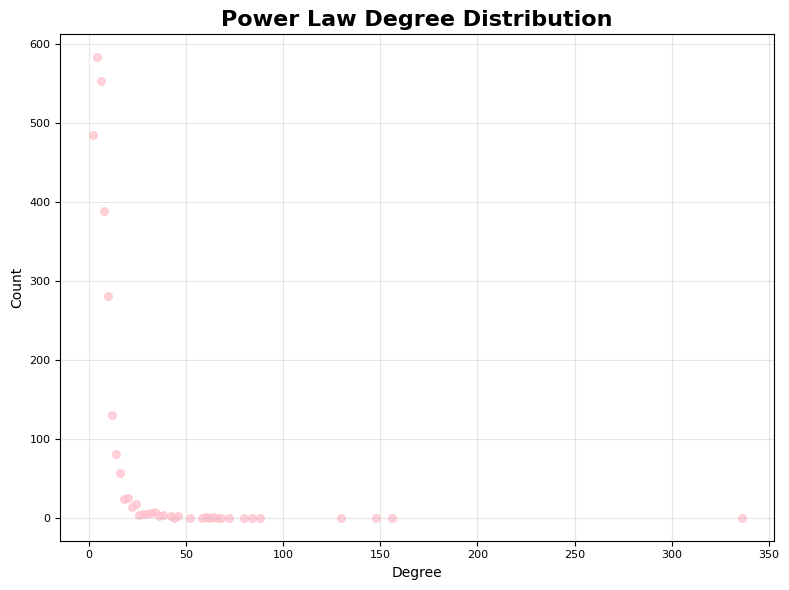

In [ ]:
# Calculate degree distribution
degrees = [G.degree(n) for n in G.nodes()]
unique_degrees, counts = np.unique(degrees, return_counts=True)

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(unique_degrees, counts, s=30, alpha=0.7, color='pink')

ax.set_xlabel('Degree', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_title('Power Law Degree Distribution', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.grid(axis='both', alpha=0.3)

x = unique_degrees
y = counts

slope, intercept = np.polyfit(np.log(x), np.log (y), 1)

# Calculate alpha
alpha = -1 - slope
print('Estimated alpha:', alpha)

plt.tight_layout()
plt.show()

Degree centrality

In [ ]:
# Print the top 5 nodes by degree centrality
table = []
for node, centrality in top_degree:
    table.append([node, G.degree(node)])
print(tabulate(table, headers=['Node', 'Degree'], tablefmt='fancy_grid'))

╒════════╤══════════╕
│   Node │   Degree │
╞════════╪══════════╡
│     35 │      336 │
├────────┼──────────┤
│   6213 │      156 │
├────────┼──────────┤
│   1365 │      148 │
├────────┼──────────┤
│   3229 │      130 │
├────────┼──────────┤
│    910 │       88 │
╘════════╧══════════╛


Clustering Coefficient

In [ ]:
clustering_coefficient = nx.clustering(G)

top_clustering = sorted(clustering_coefficient.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 nodes by clustering coefficient in a table
table = []
for node, coefficient in top_clustering:
    table.append([node, f'{coefficient:.1f}'])
print(tabulate(table, headers=['Node', 'Clustering Coefficient'], tablefmt='fancy_grid'))

╒════════╤══════════════════════════╕
│   Node │   Clustering Coefficient │
╞════════╪══════════════════════════╡
│   1694 │                        1 │
├────────┼──────────────────────────┤
│   4878 │                        1 │
├────────┼──────────────────────────┤
│   8766 │                        1 │
├────────┼──────────────────────────┤
│  13205 │                        1 │
├────────┼──────────────────────────┤
│  18251 │                        1 │
╘════════╧══════════════════════════╛


Page Rank

In [ ]:
# Compute the PageRank scores
pagerank_scores = nx.pagerank(G)

# Sort the nodes by their PageRank score and print the top 5
top_pagerank_scores = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 nodes by pagerank_scores in a table
table = []
for node, pagerank in top_pagerank_scores:
    table.append([node, f'{pagerank:.4f}'])
print(tabulate(table, headers=['Node', 'Page Rank'], tablefmt='fancy_grid'))

╒════════╤═════════════╕
│   Node │   Page Rank │
╞════════╪═════════════╡
│     35 │      0.0122 │
├────────┼─────────────┤
│   1365 │      0.0063 │
├────────┼─────────────┤
│   3229 │      0.0054 │
├────────┼─────────────┤
│   6213 │      0.0051 │
├────────┼─────────────┤
│    910 │      0.0036 │
╘════════╧═════════════╛


# Step 3

Coloring node with their label

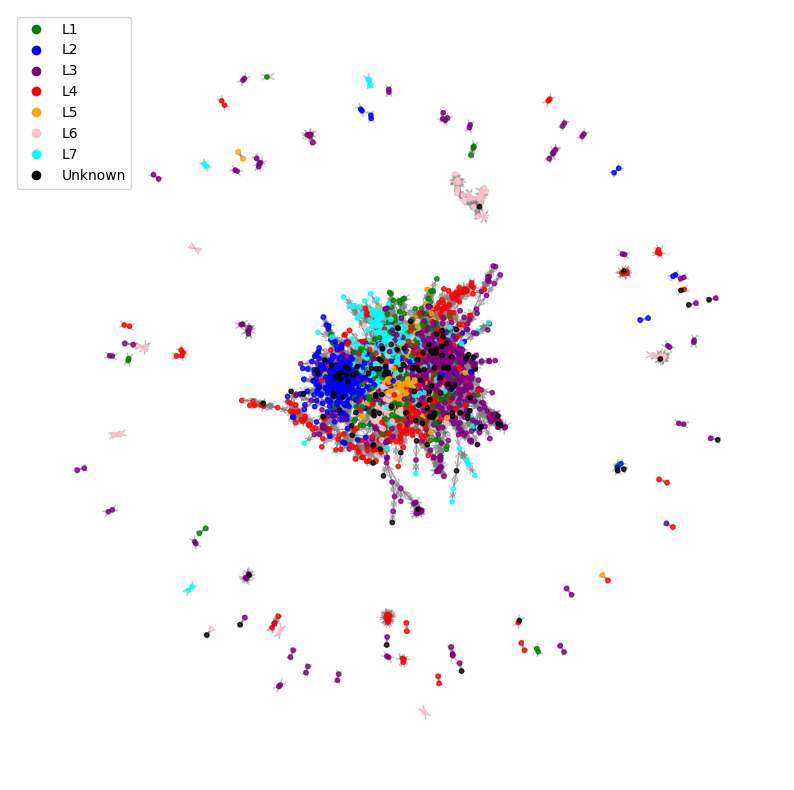

In [ ]:
# Get the node labels
labels = nx.get_node_attributes(G, "label")

# Set the colors for each label
labels_colors = {
    'L1': 'green','L2': 'blue','L3': 'purple','L4': 'red','L5': 'orange','L6': 'pink','L7': 'Cyan','Unknown': 'black',}

# Draw the network
fig = plt.figure(figsize=(10, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_color=[labels_colors[labels[node]] for node in G.nodes()], node_size=10, alpha=0.8)
edges = nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, arrows=True, arrowstyle='->', arrowsize=10, node_size=10, edge_color='gray')

# Create a legend for the node colors
legend_handles = []
for label, color in labels_colors.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8))
plt.legend(handles=legend_handles, loc='upper left')

plt.axis('off')
plt.show()

### Community detection louvain method

In [ ]:
# Community detection using louvain
louvain_communities = nx.community.louvain_communities(G, seed=1234)
Q = modularity(G, louvain_communities)

print(f"Modularity of communities using louvain: {Q}")

Modularity of communities using louvain: 0.5708727024501035


In [ ]:
print(louvain_communities)

[{288, 1118092}, {424, 218666}, {58454, 463}, {94953, 1152194, 436796, 910}, {20180, 940, 941, 129558}, {1153945, 1034, 1026, 1129798}, {949318, 1102407, 1135368, 237521, 1365, 1136442, 1031453, 1110494, 853150, 1120866, 1129443, 1105062, 1136422, 948846, 1152821, 1132922}, {1481, 399173, 1111614}, {1817, 1114502}, {35778, 1108389, 1919}, {1953, 1153724, 1153166}, {1109439, 1997, 1109542, 1108551}, {1102442, 6771, 1999}, {1119671, 2663}, {3217, 1000012}, {964248, 1103737, 3222}, {1153101, 1132157, 3223}, {1131748, 949511, 1128839, 919885, 7022, 1154169, 1125082, 3229, 1131647}, {3235, 1114222}, {854434, 3243, 350362, 1104055}, {936, 207395, 3828}, {1114664, 4274, 1119078}, {1110768, 195361, 1111304, 4329}, {1140547, 1121254, 1136310, 4335}, {4553, 1102548}, {5062, 5064, 5069, 1129106, 1120563, 5075, 1121176, 28026, 177115}, {140569, 5194, 133550}, {1110520, 5869}, {1115677, 69397, 6311}, {6344, 1112665, 200480}, {1129208, 28473, 6378}, {411092, 6741, 49895, 1153160, 1130637}, {350319, 

In [ ]:
len(louvain_communities)

710

### Community detection greedy method

In [ ]:
# find communities by greedy method
greedy_communities = greedy_modularity_communities(G, weight=None, resolution=1, cutoff=1, best_n=None)

In [ ]:
# Compute the modularity of the community structure
Q = modularity(G, greedy_communities)

print(f"Modularity of communities using greedy modularity optimization: {Q}")

Modularity of communities using greedy modularity optimization: 0.801645002434549


In [ ]:
len(greedy_communities)

104

### Is it possible to classify nodes based on identified clusters using community detection methods?

In [ ]:
# classifying labels using community detection
Labels_nodes = {label: [node for node in G.nodes() if labels[node] == label] for label in set(labels.values())}

# Modularity of communitis using labels
Label_based_communities = [set(nodes) for nodes in Labels_nodes.values()]
Q = modularity(G, Label_based_communities)

print(f"Modularity of communities using labels: {Q}")

Modularity of communities using labels: 0.5928930113933577


In [ ]:
Label_based_communities

[{164,
  1272,
  1999,
  2354,
  2653,
  2654,
  3217,
  3223,
  3231,
  3232,
  3236,
  3240,
  3243,
  4637,
  4660,
  4804,
  5038,
  5055,
  6125,
  6238,
  6311,
  6539,
  6741,
  6771,
  6782,
  8079,
  8224,
  8696,
  8699,
  9513,
  9515,
  9716,
  10169,
  10174,
  10177,
  10186,
  10793,
  11326,
  11337,
  11339,
  11342,
  12155,
  12158,
  12165,
  12169,
  12182,
  12194,
  12195,
  12197,
  12198,
  12199,
  12210,
  12211,
  12238,
  12247,
  12350,
  12960,
  13982,
  14549,
  14807,
  15429,
  15431,
  18619,
  18781,
  19231,
  20601,
  20602,
  20850,
  20942,
  22883,
  23116,
  23545,
  23738,
  24966,
  25805,
  27199,
  27203,
  27241,
  27243,
  27249,
  27250,
  27510,
  27606,
  27612,
  27627,
  27895,
  28456,
  28632,
  28640,
  28641,
  28649,
  28674,
  30895,
  30901,
  30934,
  31083,
  32260,
  32276,
  33325,
  34979,
  35854,
  36140,
  37541,
  38722,
  40124,
  40151,
  41666,
  42207,
  42209,
  42221,
  44017,
  45061,
  45188,
  45189,
  46470

In [ ]:
len(Label_based_communities)

8

# Step 4

### Most suspicious people

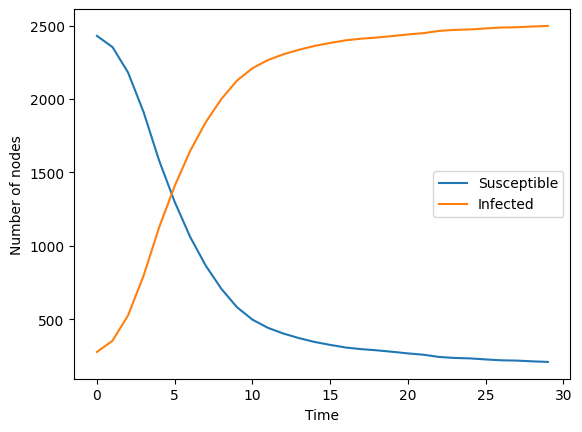

In [ ]:
# Define the SI model

def si_model(G, initial_infected_nodes, draw_flag, p=0.3):
    infected_nodes = set(initial_infected_nodes)
    susceptible_nodes = set(G.nodes()) - infected_nodes
    time = [0]
    infected_counts = [len(infected_nodes)]
    susceptible_counts = [len(susceptible_nodes)]
    new_infected_nodes_step = []
    while True:
        new_infections = set()
        for infected_node in infected_nodes:
            neighbors = set(G.neighbors(infected_node))
            susceptible_neighbors = neighbors & susceptible_nodes
            for susceptible_neighbor in susceptible_neighbors:
                if random.random() < p:
                    new_infections.add(susceptible_neighbor)
        if len(new_infections) == 0:
            break
        infected_nodes |= new_infections
        new_infected_nodes_step.append(new_infections)
        susceptible_nodes -= new_infections
        time.append(time[-1] + 1)
        infected_counts.append(len(infected_nodes))
        susceptible_counts.append(len(susceptible_nodes))
    if draw_flag == 0:
        plt.plot(time, susceptible_counts, label='Susceptible')
        plt.plot(time, infected_counts, label='Infected')
        plt.xlabel('Time')
        plt.ylabel('Number of nodes')
        plt.legend()
        plt.show()
    return infected_nodes, new_infected_nodes_step

# Run the SI model and plot the results
initial_infected_nodes =  Labels_nodes['L1']
infected_nodes = []
new_infected_nodes = []

# 10 times simulation
for i in range(10):
    this_infected_nodes, this_new_infected_nodes_step = si_model(G, initial_infected_nodes, i)
    infected_nodes.append(this_infected_nodes)
    new_infected_nodes.append(this_new_infected_nodes_step)

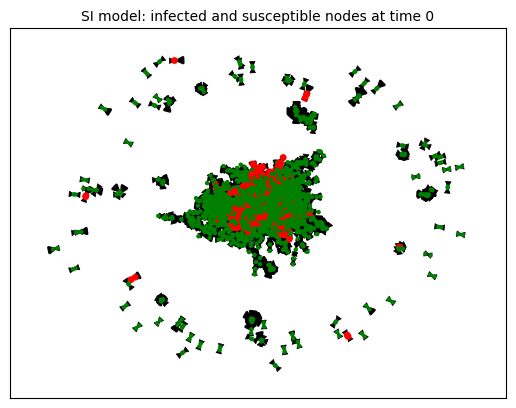

In [ ]:
node_colors = ['r' if node in initial_infected_nodes else 'g' for node in G.nodes()]
node_sizes = [15 if node in initial_infected_nodes else 5 for node in G.nodes()]
edge_widths = [2 if node in initial_infected_nodes else 0.5 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=edge_widths)

plt.title("SI model: infected and susceptible nodes at time 0", fontsize=10)

plt.show()

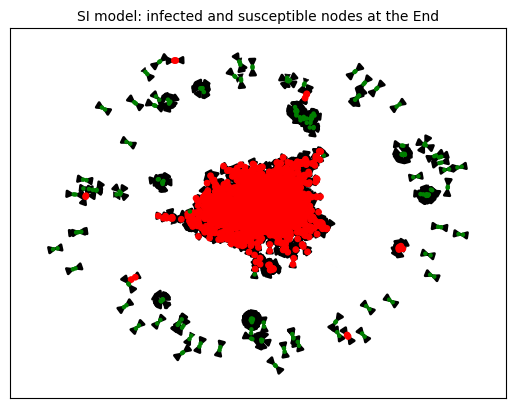

In [ ]:
node_colors = ['r' if node in infected_nodes[0] else 'g' for node in G.nodes()]
node_sizes = [15 if node in infected_nodes[0] else 5 for node in G.nodes()]
edge_widths = [2 if node in infected_nodes[0] else 0.5 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=edge_widths)

plt.title("SI model: infected and susceptible nodes at the End", fontsize=10)

plt.show()

### Unknown label nodes that fell sick in the first sim in each step

In [ ]:
print('Unknown label nodes that fell sick in the first sim in each step were:')
i = 1
for steps in new_infected_nodes[0]:
    unknown_sicks_step = [node for node in steps if node in Labels_nodes['Unknown']]
    if i >= 10:
        print(f'{i}: {unknown_sicks_step}')
    else:
        print(f'{i}:  {unknown_sicks_step}')
    i += 1

Unknown label nodes that fell sick in the first sim in each step were:
1:  [1152896, 1153166, 1153703, 1152308, 1153724, 1153728, 1152448, 1152975, 1153879, 1153891, 1152244, 1153150]
2:  [1152564, 1154176, 1136814, 1153264, 1153889, 1138027, 1153943, 1154459, 1138091, 1152436, 1153003]
3:  [1153064, 1153148, 1136791, 1152194, 1152740, 1139195, 1153280, 1152307, 1137466, 1152358, 1153942, 1152421, 1154500]
4:  [1153056, 1153065, 1153106, 1153160, 1153275, 1153577, 1153811, 1153816, 1153853, 1153866, 1153897, 1153922, 1154042, 1154251, 1152277, 1140040, 1152663, 1152673, 1136393, 1136397, 1136422, 1152944]
5:  [1154076, 1154123, 1154124, 1154169, 1154276, 1153262, 1152272, 1135894, 1152290, 1136442, 1153900, 1152379, 1152917, 1152508]
6:  [1152569, 1152633, 1135746, 1152143, 1153169, 1153183, 1153736, 1139928, 1153784, 1152761, 1138968, 1136446, 1153933, 1152910, 1154520]
7:  [1155073, 1140289, 1153091, 1152162, 1152676, 1154233, 1153287, 1140547, 1153877, 1153899]
8:  [1154103, 1152150

### In 10 iterations of the simulation the chance of Unknown nodes falling sick in the first step


In [ ]:
counts = {node: 0 for node in Labels_nodes['Unknown']}
for i in range(10):
    for node in Labels_nodes['Unknown']:
        if node in new_infected_nodes[i][0]:
            counts[node] += 1

print('In 10 iterations of the simulation the chance of nodes falling sick in the first step were:')
for node, count in counts.items():
    if count > 0:
        print(f'{node}: {(count / 10) * 100}%')

In 10 iterations of the simulation the chance of nodes falling sick in the first step were:
1138027: 40.0%
1138091: 30.0%
1152244: 50.0%
1152307: 40.0%
1152308: 90.0%
1152436: 40.0%
1152448: 30.0%
1152564: 30.0%
1152896: 70.0%
1152975: 30.0%
1153101: 10.0%
1153148: 50.0%
1153150: 30.0%
1153166: 60.0%
1153169: 30.0%
1153703: 30.0%
1153724: 40.0%
1153728: 80.0%
1153811: 30.0%
1153877: 20.0%
1153879: 40.0%
1153889: 20.0%
1153891: 90.0%
1154500: 40.0%


# Step 5

Label the unknown nodes using three strategies.

## SVM Classification

In [ ]:
# Create a dictionary mapping node IDs to labels
node_labels = dict(zip(nodes_df['NodeId'], nodes_df['Labels']))

# Create a dataset of features for each node in the graph
X = np.array([[
        node,  # node ID
        G.degree(node),  # node degree
        nx.clustering(G, node) # node clustering coefficient
    ] for node in G.nodes()])

In [ ]:
# Create a target vector with the known labels
y_known = np.array([node_labels.get(node, 'Unknown') for node in G.nodes()])

from sklearn.model_selection import train_test_split
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X[y_known != 'Unknown'], y_known[y_known != 'Unknown'], test_size=0.1, random_state=42)

In [ ]:
#  Train a classification algorithm
# Create a SVM classifier with a standard scaler
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale'))

# Train the classifier on the training set
clf.fit(X_train[:, 1:], y_train)

In [ ]:
# Predict the labels of the unknown nodes
y_unknown = clf.predict(X[y_known == 'Unknown'][:, 1:])

# Update the node labels with the predicted labels
node_labels.update(dict(zip(np.where(y_known == 'Unknown')[0], y_unknown)))

In [ ]:
# Predict the labels of all the nodes in the graph
y_all = clf.predict(X[:, 1:])

In [ ]:
# Filter the feature matrix to only include unknown nodes
X_unknown = X[y_known == 'Unknown']

# Predict the labels of the unknown nodes
y_unknown_pred = clf.predict(X_unknown[:, 1:])

df = pd.DataFrame(list(zip(X_unknown[:, 0], y_unknown_pred)), columns=["NodeId", "Labels"])
df.to_csv('Unknown Labels with SVM.csv', index=False)
df

,NodeId,Labels
0,1135589.0,L3
1,1135746.0,L3
2,1135750.0,L3
3,1135894.0,L3
4,1135899.0,L3
...,...,...
153,1154500.0,L3
154,1154520.0,L3
155,1154524.0,L3
156,1154525.0,L3


### Evaluate the performance of the algorithm on the validation set.

In [ ]:
# Predict the labels of the validation set
y_pred = clf.predict(X_val[:, 1:])

# Print the classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          L1       0.00      0.00      0.00        38
          L2       0.00      0.00      0.00        41
          L3       0.33      0.99      0.49        83
          L4       0.00      0.00      0.00        35
          L5       0.00      0.00      0.00        18
          L6       0.00      0.00      0.00        19
          L7       0.33      0.05      0.08        21

    accuracy                           0.33       255
   macro avg       0.09      0.15      0.08       255
weighted avg       0.13      0.33      0.17       255



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM using node2vec

In [ ]:
!pip install node2vec
from node2vec import Node2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [ ]:
# create vectore of graph using node2vec

node2vec = Node2Vec(G, dimensions=256, walk_length=60, num_walks=20, workers=5)
model = node2vec.fit(window=10)

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

In [ ]:
# Extract the node features and labels from the graph
node_features = [model.wv[str(node)] for node in G.nodes if G.nodes[node]["label"] != "Unknown"]
node_labels = [G.nodes[node]["label"] for node in G.nodes if G.nodes[node]["label"] != "Unknown"]

In [ ]:
# Train an SVM classifier on the labeled nodes
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(node_features, node_labels)

# Predict the labels of the unknown nodes
unknown_nodes = Labels_nodes['Unknown']
unknown_node_features = [model.wv[str(node)] for node in unknown_nodes]
unknown_node_labels = svm_classifier.predict(unknown_node_features)

# Save the predicted labels to a CSV file
df = pd.DataFrame({'NodeId': unknown_nodes, 'Labels': unknown_node_labels})
df.to_csv('Uknown Labels with SVM & Node2Vec.csv', index=False)
df

,NodeId,Labels
0,1135589,L3
1,1135746,L7
2,1135750,L7
3,1135894,L3
4,1135899,L3
...,...,...
153,1154500,L1
154,1154520,L3
155,1154524,L6
156,1154525,L6


## DecisionTree Classification using one hot encoding

In [ ]:
! pip install scikit-learn
from sklearn.tree import DecisionTreeClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Separate labeled nodes from unlabeled nodes
labeled_nodes_df = nodes_df[nodes_df["Labels"] != "Unknown"]
unlabeled_nodes_df = nodes_df[nodes_df["Labels"] == "Unknown"]

# Create feature matrix for labeled nodes
features = labeled_nodes_df[["NodeId", "Labels"]]
enc = OneHotEncoder(categories="auto", handle_unknown="ignore")
features_encoded = enc.fit_transform(features).toarray()

# Create target vector for labeled nodes
target = labeled_nodes_df["Labels"]

# Train Decision Tree on labeled nodes
clf = DecisionTreeClassifier()
clf.fit(features_encoded, target)

# Predict labels of unlabeled nodes
unlabeled_features = unlabeled_nodes_df[["NodeId", "Labels"]]
unlabeled_features_encoded = enc.transform(unlabeled_features).toarray()
predicted_labels = clf.predict(unlabeled_features_encoded)

# Update "Labels" column of nodes data frame with predicted labels
nodes_df.loc[nodes_df["Labels"] == "Unknown", "Labels"] = predicted_labels

In [ ]:
# Print out nodes with predicted labels
print("Nodes with predicted labels:")
nodes_df.loc[nodes_df["NodeId"] >= 1135589].to_csv('Unknown Labels with Decision Tree.csv', index=False)
nodes_df.loc[nodes_df["NodeId"] >= 1135589]

Nodes with predicted labels:


,NodeId,Labels
2550,1135589,L5
2551,1135746,L5
2552,1135750,L5
2553,1135894,L5
2554,1135899,L5
...,...,...
2703,1154500,L5
2704,1154520,L5
2705,1154524,L5
2706,1154525,L5


## Naive Bayes Classification using Node2Vec

In [ ]:
# Use node2vec to generate embedding vectors for each node
node_embeddings = model.wv

# Train a Naive Bayes classifier on the labeled nodes
labeled_nodes_df = nodes_df[nodes_df['Labels'] != 'Unknown']
X_train = [node_embeddings[str(node_id)] for node_id in labeled_nodes_df['NodeId']]
y_train = labeled_nodes_df['Labels']
classifier = GaussianNB()
classifier.fit(X_train, y_train)


In [ ]:
nodes_df = pd.read_excel('nodes.xlsx', usecols=['NodeId', 'Labels'])
unknown_nodes_df= nodes_df.loc[nodes_df['Labels'] == 'Unknown']

# Predict the labels of the "Unknown" nodes
unknown_nodes_df = nodes_df[nodes_df['Labels'] == 'Unknown']
X_test = [node_embeddings[str(node_id)] for node_id in unknown_nodes_df['NodeId']]
X_test = np.array(X_test).reshape(len(X_test), -1)  # Reshape the embedding vectors
predicted_labels = classifier.predict(X_test)

# Update the labels of the "Unknown" nodes
nodes_df.loc[unknown_nodes_df.index, 'Labels'] = predicted_labels


In [ ]:
# Print out nodes with predicted labels
print("Nodes with predicted labels:")
nodes_df.loc[nodes_df["NodeId"] >= 1135589].to_csv('Uknown Labels with Naive Bayes & Node2Vec.csv', index=False)
nodes_df.loc[nodes_df["NodeId"] >= 1135589]

Nodes with predicted labels:


,NodeId,Labels
2550,1135589,L3
2551,1135746,L7
2552,1135750,L7
2553,1135894,L3
2554,1135899,L3
...,...,...
2703,1154500,L1
2704,1154520,L3
2705,1154524,L6
2706,1154525,L6
